In [1]:
# import packages
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import auc
import os
from scipy.integrate import odeint
from scipy.signal import find_peaks, peak_prominences
import scipy.integrate as spi
import scipy.stats as st
from array import *
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator
import scipy.io as io
import math
import random
import pickle
from sklearn.metrics import r2_score
from scipy.interpolate import CubicSpline
from ipynb.fs.full.All_Functions import GetPopParams
from ipynb.fs.full.All_Functions import GetPopParamsOmega
from ipynb.fs.full.All_Functions import GetVLIndParams
from ipynb.fs.full.All_Functions import RandVLIndParams
from ipynb.fs.full.All_Functions import RandVLParams
from ipynb.fs.full.All_Functions import PKPDParams
from ipynb.fs.full.All_Functions import Cohort_Prep
from ipynb.fs.full.All_Functions import VLModel
from ipynb.fs.full.All_Functions import VLPKPD
from ipynb.fs.full.All_Functions import PK_Model
from ipynb.fs.full.All_Functions import PD_Model
#from ipynb.fs.full.All_Functions import SetInit
from ipynb.fs.full.All_Functions import SimulateTreatment
from ipynb.fs.full.All_Functions import Trial_Simulation
from ipynb.fs.full.All_Functions import Trial_Simulation_paramInput
from ipynb.fs.full.All_Functions import SimulateTreatmentPK
from ipynb.fs.full.All_Functions import TreatmentImpact
from ipynb.fs.full.All_Functions import CI_Calc
from ipynb.fs.full.All_Functions import ParamsPrep
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
##  --- Within-host parameters

data_file = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerResearchCenter/Schiffer Group - Shared Resources - SARSCoV2ComboModeling/Within-Host Viral Dynamics Model/NBACohort/NBACohortClusters/NBA_6Clusters_810infections.csv'
parameters_file = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerResearchCenter/Schiffer Group - Shared Resources - SARSCoV2ComboModeling/Within-Host Viral Dynamics Model/NBACohort/NBACohortClusters/estimatedIndividualParameters.txt'
# load all parameters into data frame
parameters_df = pd.read_csv(parameters_file)
# load data from clustered infections into data frame
data_df = pd.read_csv(data_file)
# list unique infection IDs included in clustering
IDs_clustered = list(data_df.ID.unique())
# list for just one group
IDs_groups = []
for i in range(0, 6):
    IDs_groups.append(list(data_df[data_df['Cluster']==i].ID.unique()))
    print(len(IDs_groups[i]))

    
Popparameters_file =  r'/Users/sesmaeil/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerResearchCenter/Schiffer Group - Shared Resources - SARSCoV2ComboModeling/Monolix/Projects/E0_I0_Vest_logitt0_SympOnsetKnown_AppendNegatives/populationParameters.txt'

Popparameters_df = pd.read_csv(Popparameters_file)

## --------------------- PK parameters -----------------------------
Indparameters_U_file = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerResearchCenter/Schiffer Group - Shared Resources - SARSCoV2ComboModeling/PK-PD Modeling/NIRestimatedIndividualParameters.txt'
Popparameters_U_file = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerResearchCenter/Schiffer Group - Shared Resources - SARSCoV2ComboModeling/PK-PD Modeling/NIRpopulationParameters(2).txt'
Indparameters_PK = pd.read_csv(Indparameters_U_file)
Popparameters_PK = pd.read_csv(Popparameters_U_file)

IDs_U = Indparameters_PK.id.unique()

145
187
137
158
79
104


In [5]:
def StandardDoseTimeSim(TrtmntStrtDay, params, 
                        PKPDInd, param_dict, PotRed, MolMass, dose, SetInit, VLPKPD,
                       TreatmentLength = 5, TreatmentFrequency = 0.5):
    X = []
    times = []
    for idi, tstart, in enumerate(TrtmntStrtDay):
        t, y, dosetimes = Trial_Simulation_paramInput(tstart, params[idi][:], 
                                                      PKPDInd[idi], param_dict[idi], 
                                                      PotRed, MolMass, dose, SetInit, VLPKPD,
                               TreatmentLength = TreatmentLength, TreatmentFrequency = TreatmentFrequency)
        T,R,E,I,V, Ag, A1, A2 = y.T
        X.append(np.log10(np.maximum(V,10**2)))
        X[idi][X[idi]==2]=1
        times.append(t)
    return X, times

In [6]:
def ParamsPrep(Cohort, CohortStyle, GetVLIndParams, RandVLParams, parameters_df, Popparameters_df, fixed_params, param_order, param_dist,
               PKPDParams, Popparameters_PK, GetPopParams, GetPopParamsOmega, Emax, IC50, Hill,PDOm, dose):

    VLparams = []
    PKPD_params = []
    param_dict = []
    for ID in Cohort:
        if CohortStyle == 'direct':
            ind_params = GetVLIndParams(parameters_df, ID, style = 'mode')
        else:
            ind_params = RandVLParams(Popparameters_df, param_dist)
            
        _dict = {**fixed_params, **ind_params}
        param_dict.append(_dict)
        params = []
        for k in param_order:
            params.append(_dict[k])
        VLparams.append(params)
        pkpd =PKPDParams(Popparameters_PK, GetPopParams, GetPopParamsOmega, Emax, IC50, Hill, dose, PDOm)
        PKPD_params.append(pkpd)
    return VLparams, PKPD_params, param_dict

In [7]:
param_order = ['beta', 'phi', 'rho', 'k', 'delta','h', 'm', 'pi', 'c', 'tAI']
fixed_params = dict({'c': 15, 'r':10, 'k':4})
param_dist = dict({'V0':'logitNormal', 'V0min': 0, 'V0max': 250, 'log10beta':'normal', 'log10phi':'normal', 'log10rho':'normal', 
                   'delta':'logNormal', 'h': 'logNormal', 'm': 'logNormal', 
                   'log10pi':'normal','tAI': 'logNormal', 'tzero':'logitNormal',
                   'tzeromin': 0.75, 'tzeromax':30})

In [8]:
def SetInit(param_dict):
    T_0 = 10**7
    R_0 = 0;
    E_0 = 0;
    I_0 = 0
    V_0 = param_dict['V0']
    #param_dict['pi']*I_0/param_dict['c']
    return [T_0, R_0, E_0, I_0, V_0]

In [9]:
# Nirmatrelvir in vitro IC50
Emax = 0.9999
IC50 = 0.0436
Hill = 3.16
PDOm = 0.026, 0.0032, 0.42
MolMass = 499.5   #g/Mol
dose =300

In [11]:
# heatmap of rebound as a function of dose and timing of therapy
# prepare cohort parameters
Emax = 0.9999
IC50 = 0.0436
Hill = 3.16
PDOm = 0.026, 0.0032, 0.42

MolMass = 499.5 

#Cohort = Cohort_Prep(IDsTot_param, Num)
CohortStyle = 'direct'
rebound_prob2 = []
rebound_prob1 = []
rebound_prob05 = []
Median_drop_VL_mat =[]
Median_VL_mat =[]
PotRed = 61
dur = 5
dose = 300
for Cohort in IDs_groups:
    rebound2 = []
    rebound1 = []
    rebound05 = []
    drop_VL = []
    VL =[]
    Median_drop_VL = []
    Median_VL = []
    for timing in ['day 1', 'day 4', 'day 7', 'day 10']: 
      #  Cohort = Cohort_Prep(IDsTot_param, Num)
        VLparams, PKPD_params, param_dict = ParamsPrep(Cohort, CohortStyle, GetVLIndParams, 
                                                   RandVLParams, parameters_df, Popparameters_df, 
                                                   fixed_params, param_order, param_dist, PKPDParams, 
                                                   Popparameters_PK, GetPopParams, GetPopParamsOmega, 
                                                   Emax, IC50, Hill,PDOm, dose)
        TrtmntStrtDay = [1 for i in range(0,len(Cohort))]
        if timing =='control':
            dose = 0
        else:
            dose = 300
        for idi in range(0, len(Cohort)):
            if timing == 'day 1':
                TrtmntStrtDay [idi] =1-param_dict[idi]['tzero']
            elif timing == 'day 4':
                TrtmntStrtDay [idi] =4-param_dict[idi]['tzero']
            elif timing =='day 7':
                TrtmntStrtDay [idi] =7-param_dict[idi]['tzero']
            elif timing == 'day 10':
                TrtmntStrtDay [idi] =10-param_dict[idi]['tzero']

        X, times = StandardDoseTimeSim(TrtmntStrtDay, VLparams, 
                                       PKPD_params, param_dict, PotRed, MolMass, dose, SetInit, VLPKPD,
                                       TreatmentLength = 5, TreatmentFrequency = 0.5)
        L2 = np.zeros(len(X))
        L1 = np.zeros(len(X))
        L05 = np.zeros(len(X))
        for ii,(x,t) in enumerate(zip(X,times)):
            if timing =='control':
                peaks2, props2 = find_peaks(x, height = 3, prominence = 2)
                peaks1, props1 = find_peaks(x, height = 3, prominence = 1)
                peaks05, props05 = find_peaks(x, height = 3, prominence = 0.5)
                if(len(peaks2)>1):
                    L2[ii]=1
                if(len(peaks1)>1):
                    L1[ii]=1
                if(len(peaks05)>1):
                    L05[ii]=1
            else:
        # -- flag rebound if increase of viral load by at least 2 log following end of treatment
                temp = np.argwhere(t>TrtmntStrtDay[ii]+dur)
                idx = temp[0][0]
                if (np.max(x[idx:])-x[idx])>2:
                    L2[ii] = 1
                if (np.max(x[idx:])-x[idx])>1:
                    L1[ii] = 1
                if (np.max(x[idx:])-x[idx])>0.5:
                    L05[ii] = 1
                t_on = np.argwhere(t >= TrtmntStrtDay[ii])[0][0]#index of treatment start
                t_target = np.argwhere(t>=TrtmntStrtDay[ii]+5)[0][0]
                drop_VL.append(x[t_target]-x[t_on])
                VL.append(x[t_target])
        if timing != 'control':         
            Median_drop_VL.append(np.median(drop_VL, axis=0))
            Median_VL.append(np.median(VL, axis=0))
        rebound1.append((np.sum(L1)/len(Cohort))*100)
        rebound2.append((np.sum(L2)/len(Cohort))*100)
        rebound05.append((np.sum(L05)/len(Cohort))*100)
    rebound_prob2.append(rebound2)
    rebound_prob1.append(rebound1)
    rebound_prob05.append(rebound05)
    Median_drop_VL_mat.append(Median_drop_VL)
    Median_VL_mat.append(Median_VL)

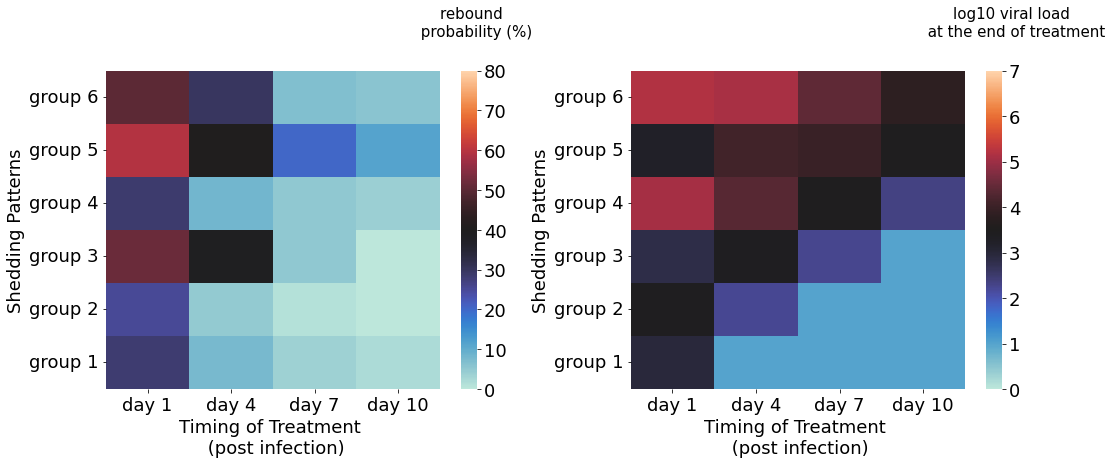

In [13]:
fig = plt.figure(figsize = (15,6))
plt.rcParams.update({'font.size': 18})
#ylabels = [ " ", 10, " ", 20, " ", 30, " ", 40, " ", 50, " ", 60, " ", 70, " ", 80, " ", 90, " ", 100, " ", 110, " ", 120]
ylabels = ['group 1', 'group 2', 'group 3', 'group 4', 'group 5', 'group 6']
plt.subplot(1,2,1)
ax = sns.heatmap(rebound_prob1, vmin =0, vmax = 80, annot = False, fmt = '.1f', 
                  yticklabels = ylabels, xticklabels = [ 'day 1', 'day 4', 'day 7', 'day 10'],
                  cmap = "icefire")
ax.invert_yaxis()
plt.ylabel('Shedding Patterns')
plt.xlabel('Timing of Treatment \n (post infection)')
fig.text(0.45, 1.05, 'rebound \n probability (%)', 
         ha='center', va='center', size = '15')
plt.subplot(1,2,2)
ax = sns.heatmap(Median_VL_mat, vmin =0, vmax = 7, cmap = 'icefire', 
                 annot = False, fmt = '.1f', yticklabels = ylabels, 
                 xticklabels = ['day 1', 'day 4', 'day 7', 'day 10'],
                 )
ax.invert_yaxis()
fig.text(0.95, 1.05, 'log10 viral load \n at the end of treatment', 
         ha='center', va='center', size = '15')
plt.ylabel('Shedding Patterns')
plt.xlabel('Timing of Treatment \n (post infection)')
plt.tight_layout()
#plt.savefig('PaperFigs/dyn-timingHeatmaps_6cluster.svg')
#plt.savefig('PaperFigs/dyn-timingHeatmaps_6cluster.pdf')

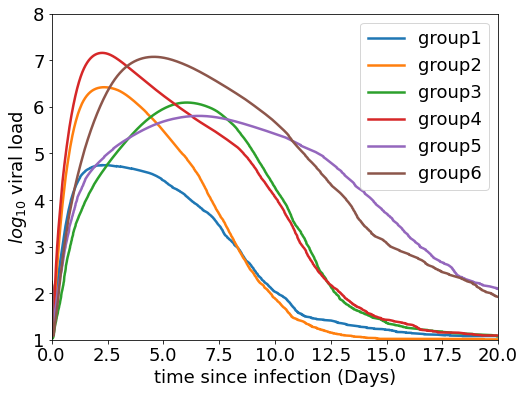

In [14]:
fig = plt.figure(figsize = (8,6))
plt.rcParams.update({'font.size': 18})
CohortStyle = 'direct'
PotRed = 61
dur = 5
dose = 0
for c, Cohort in enumerate(IDs_groups):
    VL =[]
    Median_VL = []
    VLparams, PKPD_params, param_dict = ParamsPrep(Cohort, CohortStyle, GetVLIndParams, 
                                                   RandVLParams, parameters_df, Popparameters_df, 
                                                   fixed_params, param_order, param_dist, PKPDParams, 
                                                   Popparameters_PK, GetPopParams, GetPopParamsOmega, 
                                                   Emax, IC50, Hill,PDOm, dose)
    TrtmntStrtDay = [1 for i in range(0,len(Cohort))]
    X, times = StandardDoseTimeSim(TrtmntStrtDay, VLparams, 
                                    PKPD_params, param_dict, PotRed, MolMass, dose, SetInit, VLPKPD,
                                    TreatmentLength = 5, TreatmentFrequency = 0.5)
    tlength = [len(t) for t in times]
    tmax = max(tlength)
    t_tzero = np.linspace(0, max(tlength)/1000-0.001, max(tlength))
    for j in range(0,len(Cohort)):
        if len(X[j])<max(tlength):
            X[j]= np.hstack([X[j],(np.ones(max(tlength)-len(X[j])))])
    VLmean = np.mean(X,axis = 0)
    VLstd = np.std(X, axis = 0)
    cVL = st.norm.interval(alpha=0.95, loc=VLmean, scale=VLstd/np.sqrt(len(Cohort)))
    plt.plot(t_tzero, VLmean, linewidth = 2.5, label= 'group' + str(c+1))
    plt.xlim([0, 20])
    plt.ylim([1,8])
    plt.ylabel('$log_{10}$ viral load')
    plt.xlabel('time since infection (Days)')
    plt.legend()